## Agentic RAG using LangGraph

1. Data Ingestion : Load, chunk and save the embeddings to vector DB
2. Create the llm with retriver tool, grade the retrived documents, and rewrite the question

### 1. Load the enviornment variables (API Keys)

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

### 2. Create llm and embedding model

In [3]:
from langchain_openai import ChatOpenAI
llm=ChatOpenAI()
llm.invoke("Hi")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BlTGDl5zIsnRK68pBcf5mCwyhysQ3', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f88ad9ed-7e54-42d8-b25a-ed76f09aae82-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-large",dimensions=1048)
len(embeddings.embed_query("Hi"))

1048

### 3. Data Load, splitting and storing the embdeddings of the splitted chunks into vector DB

In [7]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [27]:
urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

In [29]:
docs = [WebBaseLoader(url).load() for url in urls]

In [14]:
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=25)

In [30]:

docs_list = [item for sublist in docs for item in sublist]

In [31]:
chunks=text_splitter.split_documents(documents=docs_list)

In [32]:
len(chunks)

491

### Create a vector DB

In [17]:
from langchain_community.vectorstores import Chroma

In [33]:
vectorstore=Chroma.from_documents(
    documents=chunks,
    collection_name="rag-chrome",
    embedding=embeddings    
)

In [34]:
retriever=vectorstore.as_retriever()

In [37]:
retriever.invoke("types of reward hacking?")

[Document(metadata={'language': 'en', 'title': "Reward Hacking in Reinforcement Learning | Lil'Log", 'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for real-world deployment of more autonomous use cases of AI models.', 'source': 'https://lilianweng.githu

### 4. Start creating the tools 

In [21]:
from langchain.tools.retriever import create_retriever_tool

In [ ]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

In [35]:
tools = [retriever_tool]

In [36]:
llm_with_tool=llm.bind_tools(tools)

In [39]:
llm_with_tool.invoke("As per Lilian Weng  what are the types of reward hacking?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2J4irfTePzGIeJMGj9xWSN6E', 'function': {'arguments': '{"query":"types of reward hacking according to Lilian Weng"}', 'name': 'retrieve_india_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 80, 'total_tokens': 105, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BlWNiyil9G0U7Dm3GIEnpxom6NXLO', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0fef77ce-e829-4042-894e-5eef4e46ff5a-0', tool_calls=[{'name': 'retrieve_india_posts', 'args': {'query': 'types of reward hacking according to Lilian Weng'}, 'id': 'call_2J4irfTePzGIeJMGj9xWSN6E', 'type': 'tool_call'}], usage_metadata={

In [41]:
from typing import Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

In [42]:
class AgentState(TypedDict):
    messages : Annotated[Sequence[BaseMessage], add_messages]

In [43]:
## Node

def llm_router(state: AgentState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user."""


    response = llm_with_tool.invoke(state["messages"])
    return {"messages" : [response]}


In [44]:
from pydantic import BaseModel, Field
class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    grade : str = Field(description="Relavance check 'yes' if relavant else 'no' if not relevant")

In [46]:
def grade_documents(state: AgentState):
    pass


In [47]:
def generate_response(state: AgentState):
    pass

In [48]:
def rewrite_question(state: AgentState):
    pass

In [49]:
from langgraph.graph import StateGraph,START,END

In [77]:
workflow=StateGraph(AgentState)

In [78]:
workflow.add_node("llm_router", llm_router)
workflow.add_node("retriever", retriever_tool)
workflow.add_node("generate_response", generate_response)
workflow.add_node("rewrite_question", rewrite_question)


In [79]:
from langgraph.prebuilt import tools_condition

In [80]:
workflow.add_edge(START, "llm_router")


In [81]:
workflow.add_conditional_edges("llm_router", 
                               tools_condition,
                                {
                               "tool":"retriever",
                               END:END
                               })


In [82]:

workflow.add_conditional_edges(
    "retriever",
    grade_documents,
    {
        "generate": "generate_response",
        "rewrite" : "rewrite_question"
    }    
)


In [83]:

workflow.add_edge("rewrite_question", "llm_router")
workflow.add_edge("generate_response", END)

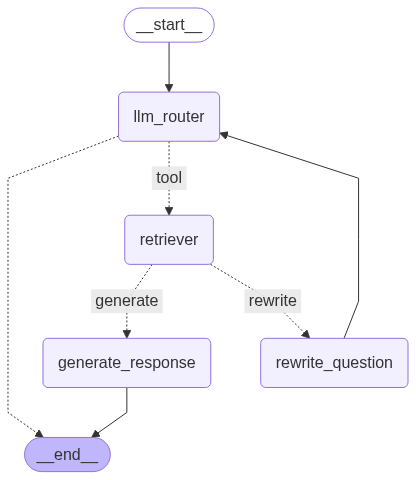

In [84]:
workflow.compile()